In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# предварительно сохраненный в виде .gz исходный train.csv
train = pd.read_csv(
    'train_dataset_train.csv.gz',
    sep=',')

test = pd.read_csv(
    'test_dataset_test.csv',
    sep=';')

In [3]:
train[:2]

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00.0,Гурьевск,8.21,young,1
1,0,A00.0,Калининград,3.20,children,1


In [4]:
train.columns

Index(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'VISIT_MONTH_YEAR', 'AGE_CATEGORY',
       'PATIENT_ID_COUNT'],
      dtype='object')

<AxesSubplot:xlabel='VISIT_MONTH_YEAR', ylabel='Density'>

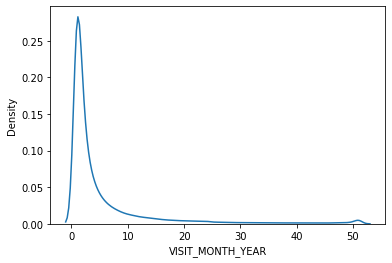

In [5]:
sns.kdeplot(train.groupby(by=['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY']
              )['VISIT_MONTH_YEAR'].count())

In [6]:
from sklearn.metrics import r2_score

In [7]:
mean_df = (train[[i.split('.')[1] != '21' for i in train['VISIT_MONTH_YEAR'].astype(str)]]
 .groupby(by=['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'])
 .agg(mean_patients=('PATIENT_ID_COUNT', 'mean'))
 .reset_index())

In [8]:
last_val = (train[train['VISIT_MONTH_YEAR'] < 4.21]
            .sort_values(by='VISIT_MONTH_YEAR', ascending=True)
            .drop_duplicates(
                subset=['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'],
                keep='last')
            .rename(columns={'PATIENT_ID_COUNT': 'mean_patients'})
            )

last_val = (train[train['VISIT_MONTH_YEAR'] == 3.21]
            .rename(columns={'PATIENT_ID_COUNT': 'mean_patients'})
            )

In [9]:
# костыли обработки месяца для графика загруженности
train['visit_year_month'] = [float('{}.{}'.format(i.split('.')[1], i.split('.')[0])) 
for i in train['VISIT_MONTH_YEAR'].astype(str)]

train['visit_year_month'] = [i + 18 if i < 10 else i for i in train['visit_year_month']]

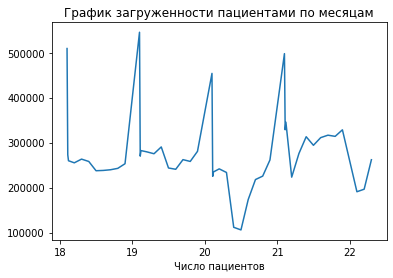

In [10]:
plt.title('График загруженности пациентами по месяцам')
plt.plot(train.groupby(['visit_year_month'])['PATIENT_ID_COUNT'].sum())
plt.xlabel('Год/месяц')
plt.xlabel('Число пациентов');

# Идея

Кажется, что для месяца, который мы предсказываем, можно использовать множитель увеличения месяк к месяцу (в 21м году такой подход работает, как видим ниже)

In [11]:
# исходный R2
r2_score(train[train['VISIT_MONTH_YEAR']==4.21]['PATIENT_ID_COUNT'], 
         train[train['VISIT_MONTH_YEAR']==4.21].merge(
             last_val[['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY','mean_patients']], 
             how='left').fillna(0)['mean_patients'])

0.8912246376349479

In [12]:
# R2 с множителем
r2_score(train[train['VISIT_MONTH_YEAR']==4.21]['PATIENT_ID_COUNT'], 
         train[train['VISIT_MONTH_YEAR']==4.21].merge(
             last_val[['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY','mean_patients']], 
             how='left').fillna(0)['mean_patients'] * 1.3)

0.9267111814618452

In [13]:
sample = pd.read_csv(
    'sample_solution.csv',
    sep=';')

In [14]:
march_val = train[train['VISIT_MONTH_YEAR'] == 3.22]

In [15]:
res = (test
 .merge(
     march_val[['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY', 'PATIENT_ID_COUNT']], 
     how='left')
 .fillna(0))

res['PATIENT_ID_COUNT'] = res['PATIENT_ID_COUNT'] * 1.3

In [16]:
res['PATIENT_ID_COUNT'] = res['PATIENT_ID_COUNT'].astype(int)
res['VISIT_MONTH_YEAR'] = '04.22'

In [17]:
res.to_csv('baseline_multiply.csv', 
           index=False,
           sep=';')

In [18]:
len(res), len(sample)

(39373, 39373)